# Prepare Environment

* Install Dependencies
* Load Modules

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers, optimizers, metrics, losses, utils, applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt

# Prepare Dataset

* Download the ''Oxford-IIIT Pet'' dataset.
* Prepare ''train'' and ''test'' splits.
* Preprocess the input dataset. Preprocessing step involves:
    * Resize images to 128x128 size.
    * Image normalization in range [0, 1].
    * Mask realignment from [1, 2, 3] to [0, 1, 2].

In [ ]:
# Load Oxford-IIIT Pet Dataset
train_ds, test_ds = tfds.load(
    'oxford_iiit_pet:3.*.*',
    split=['train', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteP33XA0/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteP33XA0/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 128

def preprocess(item):
    image, mask = item['image'], item['segmentation_mask']

    # Resize image and mask to IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])

    # Normalize the image and realign the mask.
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    
    return image, mask

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

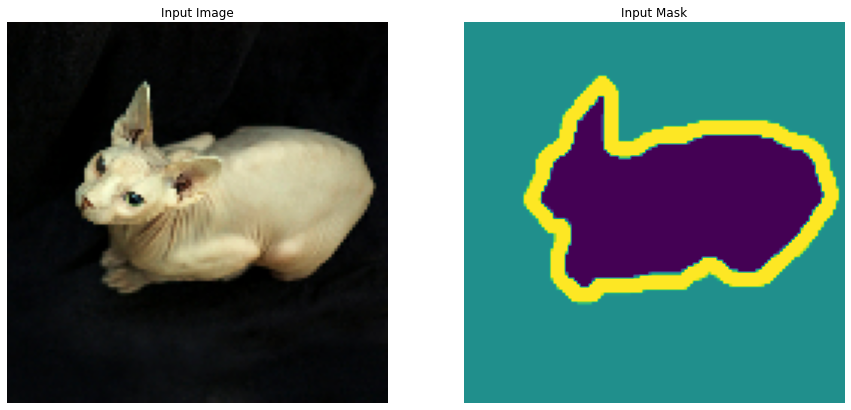

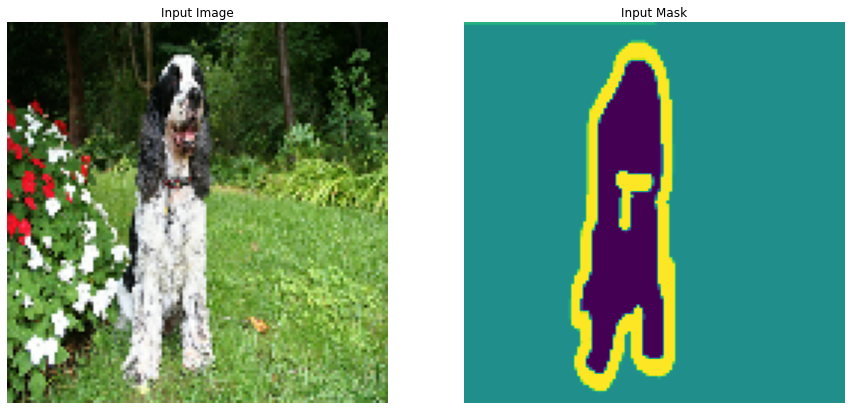

In [ ]:
def display(display_list, title=['Input Image', 'Input Mask', 'Predicted Mask']):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train_prep_ds.take(2):
    display([image, mask])

# Model Architecture

In [ ]:
LEARNING_RATE = 0.001
N_CLASSES = 3

layer_id = -1
def get_layer_id():
    global layer_id
    layer_id += 1
    
    return str(layer_id)
    
def get_regular_conv_block(filters, strides):
    return tf.keras.Sequential(
        [
            layers.Conv2D(filters, 3, padding='same', strides=strides),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='regular_conv_block_' + get_layer_id()
    )

def get_dsc_block(filters, strides):
    return tf.keras.Sequential(
        [
            layers.DepthwiseConv2D(3, padding='same', strides=strides),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, 1, padding='same', strides=1),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='dsc_block_' + get_layer_id()
    )

def get_conv_upsampling_block(filters):
    """
        It creates a block to upsample i.e. increase the spatial dimensions
        of the inputs.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    kwargs = dict(strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
    
    return tf.keras.Sequential(
        [
            layers.Conv2DTranspose(filters, 3, **kwargs),
            layers.BatchNormalization(),
            layers.ReLU()
        ],
        name='conv_upsampling_block_' + get_layer_id()
    )

def get_conv_builder(block_type='conv'):
    if (block_type == 'conv'):
        return get_regular_conv_block
    elif (block_type == 'dsc'):
        return get_dsc_block
    else:
        raise ValueError('Invalid block type: ', block_type)

def create_model(conv_type='conv'):
    get_conv_block = get_conv_builder(conv_type)
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        get_regular_conv_block(32, strides=2),
        get_conv_block(64, strides=1),
        get_conv_block(128, strides=2),
        get_conv_block(128, strides=1),
        get_conv_block(256, strides=2),
        get_conv_block(256, strides=1),
        get_conv_block(512, strides=2),
        get_conv_block(512, strides=1),
        get_conv_block(512, strides=1),
        get_conv_block(512, strides=1),
        get_conv_block(512, strides=1),
        get_conv_block(512, strides=1),
        get_conv_block(1024, strides=2),
        get_conv_upsampling_block(512),
        get_conv_upsampling_block(256),
        get_conv_upsampling_block(128),
        get_conv_upsampling_block(64),
        get_conv_upsampling_block(3),
    ])
    
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
    
    return model

# Training Functions

In [ ]:
EPOCHS = 50
BATCH_SIZE = 16

def train(model, tds, vds, epochs, callbacks=[]):
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE) if vds else None
    history = model.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)

    return history

# Experiments

We run two experiments. One with the regular convolution model and the second with convolution blocks replaced with depthwise convolution blocks. The model architecture is based on MobileNets.

## Convolution Model

In [ ]:
conv_model = create_model()
conv_model.summary(line_length=90)

Model: "sequential_10"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 regular_conv_block_180 (Sequential)    (None, 64, 64, 32)                  1024          
                                                                                          
 regular_conv_block_181 (Sequential)    (None, 64, 64, 64)                  18752         
                                                                                          
 regular_conv_block_182 (Sequential)    (None, 32, 32, 128)                 74368         
                                                                                          
 regular_conv_block_183 (Sequential)    (None, 32, 32, 128)                 148096        
                                                                                          
 regular_conv_block_184 (Sequential)    (None, 16, 16, 256)        

In [ ]:
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True)
tds = tds.batch(BATCH_SIZE)
vds = test_prep_ds.batch(256).cache()

train(conv_model, tds, vds, epochs=EPOCHS)

Epoch 1/50
230/230 [==============================] - 69s 241ms/step - loss: 0.8638 - accuracy: 0.5524 - val_loss: 1.8870 - val_accuracy: 0.4178
Epoch 2/50
230/230 [==============================] - 45s 197ms/step - loss: 0.7825 - accuracy: 0.5879 - val_loss: 0.9904 - val_accuracy: 0.5335
Epoch 3/50
230/230 [==============================] - 45s 196ms/step - loss: 0.7417 - accuracy: 0.5999 - val_loss: 0.8176 - val_accuracy: 0.5812
Epoch 4/50
230/230 [==============================] - 45s 197ms/step - loss: 0.7069 - accuracy: 0.6104 - val_loss: 0.8350 - val_accuracy: 0.5694
Epoch 5/50
230/230 [==============================] - 45s 196ms/step - loss: 0.6662 - accuracy: 0.6323 - val_loss: 0.6599 - val_accuracy: 0.6387
Epoch 6/50
230/230 [==============================] - 45s 197ms/step - loss: 0.6244 - accuracy: 0.6559 - val_loss: 0.6552 - val_accuracy: 0.6521
Epoch 7/50
230/230 [==============================] - 45s 197ms/step - loss: 0.5839 - accuracy: 0.6841 - val_loss: 0.6145 - val_ac

In [ ]:
address = 0x7f04fa6ded10
history = ctypes.cast(address, ctypes.py_object).value
print(history.history['val_accuracy'])

[0.41776758432388306, 0.533526599407196, 0.5811605453491211, 0.5693544149398804, 0.6387039422988892, 0.6520975232124329, 0.6795170307159424, 0.6907436847686768, 0.6878933906555176, 0.6972235441207886, 0.6991397738456726, 0.7013022899627686, 0.6913207173347473, 0.7060819268226624, 0.7114714980125427, 0.7159922122955322, 0.7046121954917908, 0.7180916666984558, 0.723698079586029, 0.7181515097618103, 0.7168654799461365, 0.7236546874046326, 0.7165464162826538, 0.7247695326805115, 0.7257992625236511, 0.848182737827301, 0.8535172343254089, 0.8465073704719543, 0.8553475141525269, 0.8561900854110718, 0.8554879426956177, 0.8535708785057068, 0.8283787369728088, 0.8518640398979187, 0.8565909266471863, 0.856099009513855, 0.8549239635467529, 0.8350458741188049, 0.8416408896446228, 0.8559480905532837, 0.8569785952568054, 0.8585950136184692, 0.8581680059432983, 0.8579917550086975, 0.8571770191192627, 0.8571709394454956, 0.8579334020614624, 0.8576110005378723, 0.8577625751495361, 0.8553772568702698]


## Depthwise Convolution Model

In [ ]:
dsc_model = create_model(conv_type='dsc')
dsc_model.summary(line_length=90)

Model: "sequential_11"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 regular_conv_block_198 (Sequential)    (None, 64, 64, 32)                  1024          
                                                                                          
 dsc_block_199 (Sequential)             (None, 64, 64, 64)                  2816          
                                                                                          
 dsc_block_200 (Sequential)             (None, 32, 32, 128)                 9728          
                                                                                          
 dsc_block_201 (Sequential)             (None, 32, 32, 128)                 18816         
                                                                                          
 dsc_block_202 (Sequential)             (None, 16, 16, 256)        

In [ ]:
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True)
tds = tds.batch(BATCH_SIZE)
vds = test_prep_ds.batch(256).cache()

train(dsc_model, tds, vds, epochs=EPOCHS)

Epoch 1/50
230/230 [==============================] - 44s 162ms/step - loss: 0.8378 - accuracy: 0.6490 - val_loss: 0.9283 - val_accuracy: 0.6302
Epoch 2/50
230/230 [==============================] - 32s 137ms/step - loss: 0.7355 - accuracy: 0.6930 - val_loss: 0.9069 - val_accuracy: 0.5555
Epoch 3/50
230/230 [==============================] - 32s 138ms/step - loss: 0.6676 - accuracy: 0.7207 - val_loss: 0.6702 - val_accuracy: 0.7103
Epoch 4/50
230/230 [==============================] - 32s 138ms/step - loss: 0.6160 - accuracy: 0.7390 - val_loss: 0.6181 - val_accuracy: 0.7322
Epoch 5/50
230/230 [==============================] - 32s 138ms/step - loss: 0.5703 - accuracy: 0.7547 - val_loss: 0.6119 - val_accuracy: 0.7329
Epoch 6/50
230/230 [==============================] - 32s 139ms/step - loss: 0.5408 - accuracy: 0.7641 - val_loss: 0.6348 - val_accuracy: 0.7285
Epoch 7/50
230/230 [==============================] - 32s 138ms/step - loss: 0.5111 - accuracy: 0.7758 - val_loss: 0.6107 - val_ac

In [ ]:
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = test_prep_ds.batch(256).cache()

train(dsc_model, tds, vds, epochs=EPOCHS)

Epoch 1/50
230/230 [==============================] - 56s 171ms/step - loss: 0.8263 - accuracy: 0.6682 - val_loss: 0.9455 - val_accuracy: 0.5802
Epoch 2/50
230/230 [==============================] - 31s 133ms/step - loss: 0.7282 - accuracy: 0.7139 - val_loss: 0.8733 - val_accuracy: 0.5940


KeyboardInterrupt: ignored

In [ ]:
import ctypes

address = 0x7f04fa85ce50
history = ctypes.cast(address, ctypes.py_object).value
print(history.history['val_accuracy'])

[0.6301913857460022, 0.5555415749549866, 0.7103028893470764, 0.732190728187561, 0.7328851819038391, 0.7285441160202026, 0.7388788461685181, 0.7475478053092957, 0.7639236450195312, 0.7653301358222961, 0.767617404460907, 0.7749108672142029, 0.7716068029403687, 0.7876561880111694, 0.7858603000640869, 0.7876552939414978, 0.7872483134269714, 0.7742673754692078, 0.7942866086959839, 0.7849458456039429, 0.7967032194137573, 0.7961833477020264, 0.7788451910018921, 0.7914223074913025, 0.795545756816864, 0.7925724387168884, 0.7974746823310852, 0.7963361740112305, 0.7993516325950623, 0.7978805303573608, 0.7983897924423218, 0.7987685203552246, 0.8006842136383057, 0.8009941577911377, 0.802056074142456, 0.7863645553588867, 0.7984693050384521, 0.7920119762420654, 0.8006428480148315, 0.7988910675048828, 0.8001599311828613, 0.8007596135139465, 0.8014635443687439, 0.7962427735328674, 0.790885329246521, 0.8023837208747864, 0.8045990467071533, 0.8042879700660706, 0.8034917712211609, 0.8061124086380005]


# Results

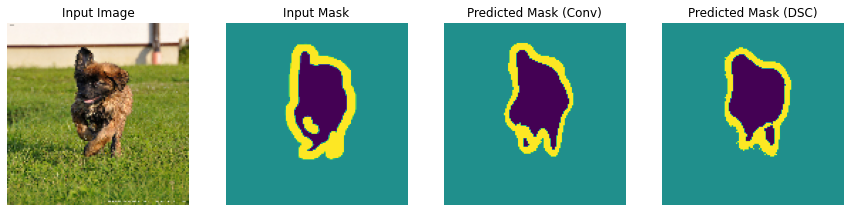

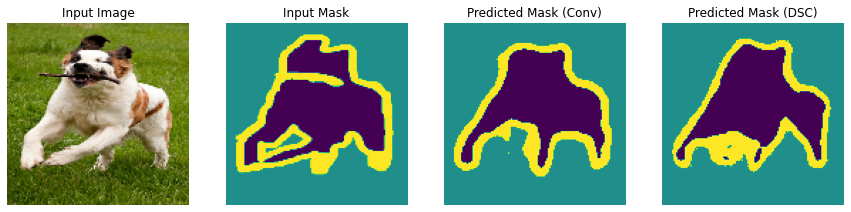

In [ ]:
def create_mask(pred_mask):
    background_mask = pred_mask[..., 1] + 0.000000001
    pred_mask = tf.stack([pred_mask[..., 0], background_mask, pred_mask[..., 2]], axis=-1)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(ds, conv_model, dsc_model):
    for image, mask in ds:
        conv_mask = conv_model.predict(image)
        dsc_mask = dsc_model.predict(image)
        
        display_list = [image[0], mask[0], create_mask(conv_mask), create_mask(dsc_mask)]
        titles = ['Input Image', 'Input Mask', 'Predicted Mask (Conv)', 'Predicted Mask (DSC)']
        
        display(display_list, titles)

ds = test_prep_ds.batch(2).take(2)
show_predictions(ds, conv_model, dsc_model)

# Benchmarks

In [ ]:
def convert_to_tflite(model, output_file=None):
    # Convert the model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
      tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
      tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
    ]
    
    tflite_model = converter.convert()
    open(output_file, "wb").write(tflite_model) if output_file else None
    
    return tflite_model

conv_tflite = convert_to_tflite(conv_model, 'conv_model.tflite')
dsc_tflite = convert_to_tflite(conv_model, 'dsc_model.tflite')

INFO:tensorflow:Assets written to: /tmp/tmph2ex8g5u/assets


INFO:tensorflow:Assets written to: /tmp/tmph2ex8g5u/assets


INFO:tensorflow:Assets written to: /tmp/tmpoanex88f/assets


INFO:tensorflow:Assets written to: /tmp/tmpoanex88f/assets


In [ ]:
import numpy as np
from datetime import datetime

def measure_time(fn):
    startTime = datetime.now()
    result = fn()
    endTime = datetime.now()
    
    duration = endTime - startTime
    print('Processing times: ', duration.seconds, ' seconds')
    
    return result

def benchmark(model_path, batch_size=1000):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_data = np.random.random_sample(input_details[0]['shape']).astype('float32')
    interpreter.set_tensor(input_details[0]['index'], input_data)

    for i in range(batch_size):
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])

print('Benchmarking Convolution Model: ')
measure_time(lambda: benchmark('conv_model.tflite'))

print('Benchmarking Depthwise Separable Convolution Model: ')
measure_time(lambda: benchmark('dsc_model.tflite'))

Benchmarking Convolution Model: 
Processing times:  85  seconds
Benchmarking Depthwise Separable Convolution Model: 
Processing times:  81  seconds


In [ ]:
def benchmark_ds(model, rounds=500):
    batch = tf.random.uniform((256, IMG_SIZE, IMG_SIZE, 3))

    for i in range(rounds):
        model.evaluate(batch)

print('Benchmarking Convolution Model: ')
measure_time(lambda: benchmark_ds(conv_model))

print('Benchmarking Depthwise Separable Convolution Model: ')
measure_time(lambda: benchmark_ds(dsc_model))

8/8 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Processing times:  55  seconds
Benchmarking Depthwise Separable Convolution Model: 
8/8 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Processing times:  57  seconds
